In [70]:
using PyPlot, StatsBase, Printf, DelimitedFiles;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

### Potential energy function

In [71]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0], k=1.0)

0.0

### Proposal distribution

In [72]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 -0.02431191851760728

### Replica MCMC without exchange

In [85]:
nreplica = 4
temperature_array = [0.01, 0.10, 0.30, 0.40];
nstep = 100;
nexchange = 200;

x_array = []
for ireplica = 1:nreplica
    x = zeros(Float64, nexchange);
    x[1, :] .= 0.0;
    push!(x_array, x)
end

for iexchange = 2:nexchange
    for ireplica = 1:nreplica
        x_array[ireplica][iexchange, :] .= propagate_mcmc(y -> V(y, k=1.0), proposal_fun, x_array[ireplica][iexchange-1, :], temperature_array[ireplica], nstep=nstep);
    end
    # do not exchange
end

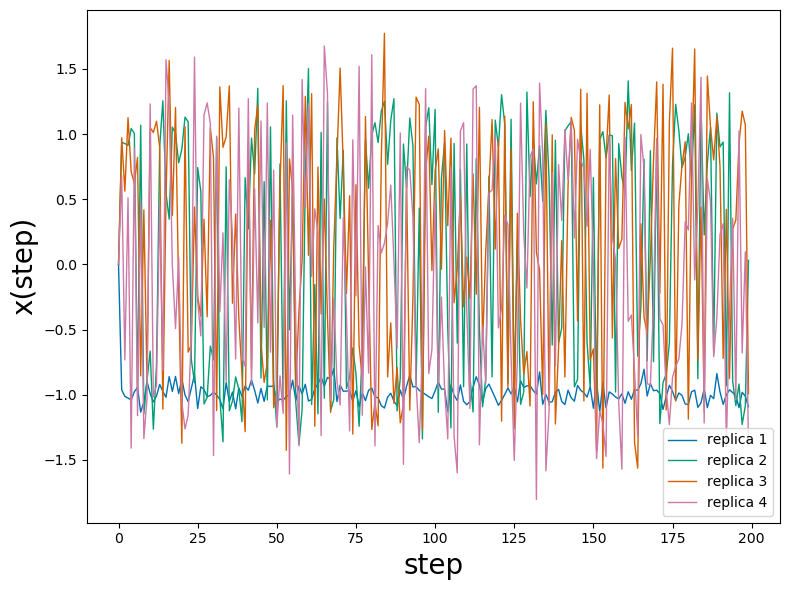

In [86]:
fig, ax = subplots(figsize=(8, 6))
for ireplica = 1:nreplica
    ax.plot(x_array[ireplica], linewidth=1.0)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

### Replica exchange MCMC

In [90]:
x = 1
y = 2


2

In [91]:
x, y = y, x

(2, 1)

In [92]:
x

2

In [93]:
y

1

In [94]:
function exchange_temperature!(m2i, i2m, icount, x_array, pot_fun::Function, temperature_array)
    nreplica = length(x_array)

    if mod(icount, 2) == 0
        m_lower = 1:2:(nreplica-1)
        m_higher = 2:2:nreplica
    else
        m_lower = 2:2:(nreplica-1)
        m_higher = 3:2:nreplica
    end
    t_lower = temperature_array[m_lower]
    t_higher = temperature_array[m_higher]
    b_lower = 1.0 ./ t_lower
    b_higher = 1.0 ./ t_higher

    i_lower = m2i[m_lower]
    i_higher = m2i[m_higher]
    v_lower = map(pot_fun, x_array[i_lower])
    v_higher = map(pot_fun, x_array[i_higher])
    
    iaccepted = 0
    for ipair = 1:length(m_higher)
        delta = (b_higher[ipair] - b_lower[ipair]) * (v_lower[ipair] - v_higher[ipair])
        if exp(-delta) > rand()
            m2i[m_lower[ipair]], m2i[m_higher[ipair]] = m2i[m_higher[ipair]], m2i[m_lower[ipair]]
            i2m[i_lower[ipair]], i2m[i_higher[ipair]] = i2m[i_higher[ipair]], i2m[i_lower[ipair]]
            iaccepted += 1
        end
    end

    return iaccepted / length(m_higher)
end

exchange_temperature! (generic function with 1 method)

In [95]:
nreplica = 4
temperature_array = [0.001, 0.1, 0.5, 1.0];
nstep = 100;
nexchange = 1000;
m2i = collect(1:nreplica)
i2m = collect(1:nreplica)

x_array = []
for ireplica = 1:nreplica
    x = zeros(Float64, nexchange);
    x[1, :] .= -1.0;
    push!(x_array, x)
end

icount = 0
acceptance_ratio = 0.0
for iexchange = 2:nexchange
    for ireplica = 1:nreplica
        x_array[ireplica][iexchange:iexchange] .= propagate_mcmc(y -> V(y, k=1.0), proposal_fun, x_array[ireplica][(iexchange-1):(iexchange-1)], temperature_array[i2m[ireplica]], nstep=nstep);
    end
    x2_array = map(x -> x[iexchange, :], x_array)
    acceptance_ratio += exchange_temperature!(m2i, i2m, icount, x2_array, y -> V(y, k=1.0), temperature_array)
    icount += 1
end
acceptance_ratio = acceptance_ratio / nexchange

0.5525

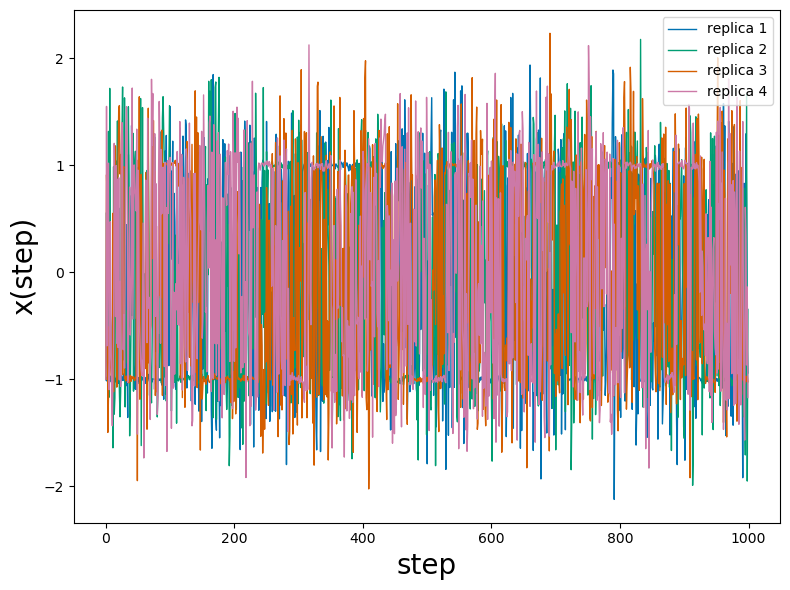

In [103]:
fig, ax = subplots(figsize=(8, 6))
for ireplica = 1:nreplica
    ax.plot(x_array[ireplica], linewidth=1.0)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

### Trajectory analysis

In [93]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [94]:
pmf_observed, _ = getpmf(trajectory, grid_x = collect(x_grid), bandwidth=0.05);

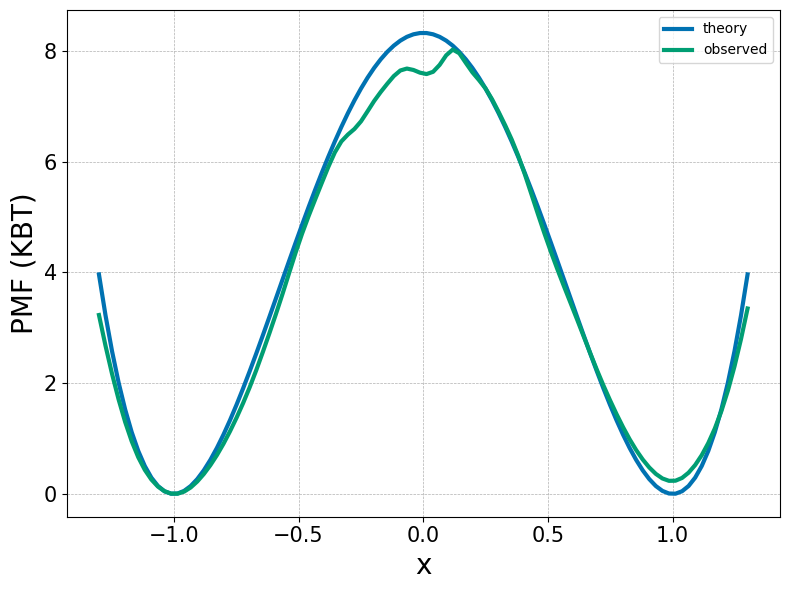

In [104]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("mcmc_single.png", dpi=350)